In [136]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import librosa
import tensorflow as tf
from tensorflow.image import resize

## Visualize Single Audio file

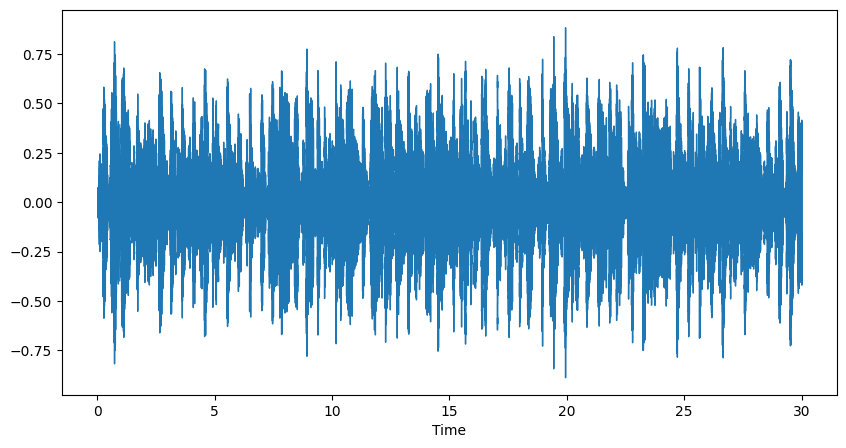

In [137]:
#file = "./genres_original/blues/blues.00000.wav"
file = "./genres_original/blues/blues.00000.wav"
data, sample_rate = librosa.load(file, sr = 22050)
plt.figure(figsize=(10,5))
librosa.display.waveshow(data, sr=sample_rate)

##### It will be difficult to run any models on this 30 sec wav file so we will divide the audio into chunks to effectively extract information from the audio file

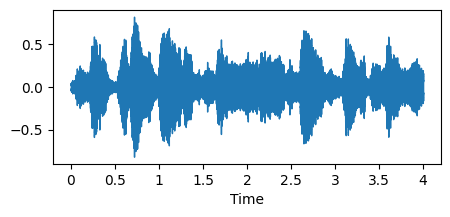

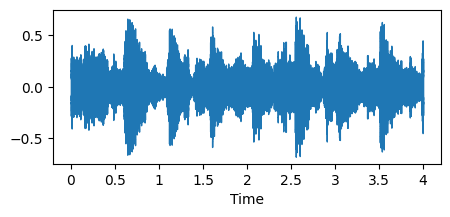

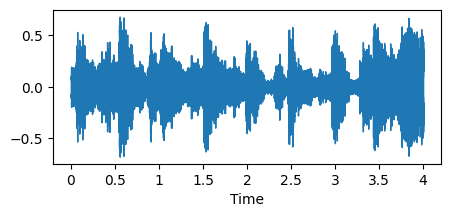

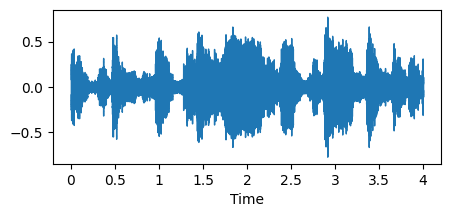

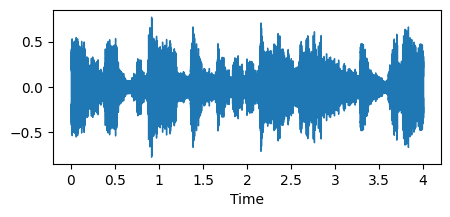

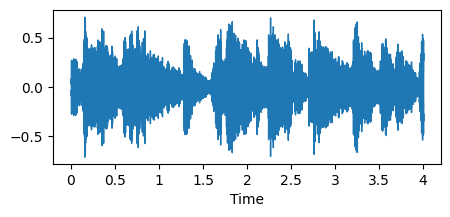

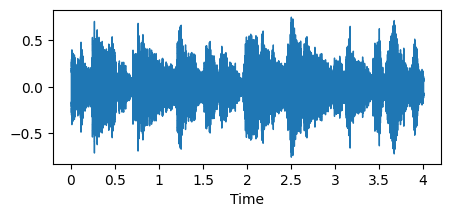

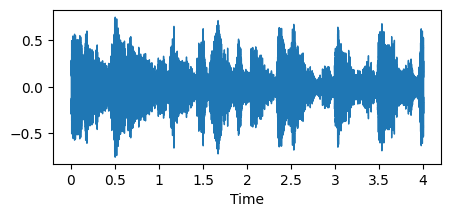

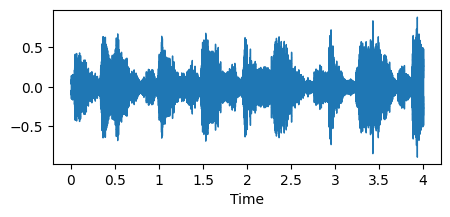

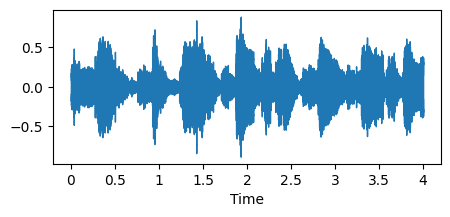

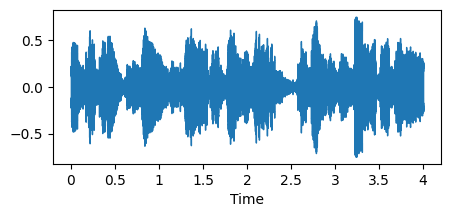

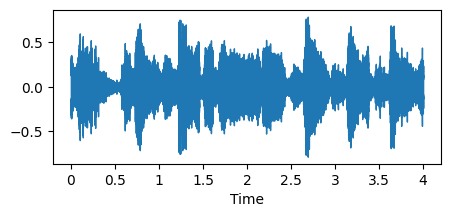

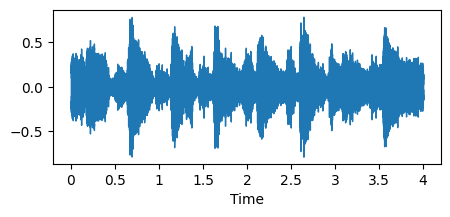

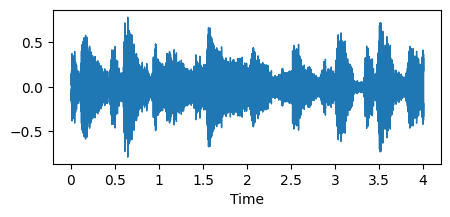

In [138]:
#file = "./genres_original/blues/blues.00000.wav"
# we want to keep the original sampling rate
data, sample_rate = librosa.load(file, sr = None)

# Defining how long each chunk is and the amount of overlap between chunks
chunk_length = 4 # in seconds
overlap_length = 2

# total samples in file is the sampling rate * duration 
# converting our chunk lengths to samples
chunk_samples = chunk_length * sample_rate
overlap_samples = overlap_length * sample_rate

# calculating how many chunks we have for iteration
num_chunks = int(np.ceil((len(data) - chunk_samples) / (chunk_samples - overlap_samples)))

for i in range(num_chunks):
    # want to display each chunk so we need to calculate start and end points
    start = i * (chunk_samples - overlap_samples)
    end = start + chunk_samples

    chunk = data[start:end]
    plt.figure(figsize=(5,2))
    librosa.display.waveshow(chunk, sr=sample_rate)
    plt.show()

We can see each 4 second audio chunk and its overlap with the ending half of the first file being the start of the next
Next we will visualize the wav files as mel spectrograms

In [139]:
def plot_melspectrogram_chunks(data, sr):

    chunk_length = 4 # in seconds
    overlap_length = 2

    # total samples in file is the sampling rate * duration 
    # converting our chunk lengths to samples
    chunk_samples = chunk_length * sample_rate
    overlap_samples = overlap_length * sample_rate

    # calculating how many chunks we have for iteration
    num_chunks = int(np.ceil((len(data) - chunk_samples) / (chunk_samples - overlap_samples)))

    for i in range(num_chunks):
        # want to display each chunk so we need to calculate start and end points
        start = i * (chunk_samples - overlap_samples)
        end = start + chunk_samples
        
        # chunk data
        chunk = data[start:end]
        
        mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        print(mel_spectrogram.shape)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref = np.max)

        plt.figure(figsize=(10,4))
        librosa.display.specshow(mel_spectrogram_db, sr=sr,x_axis='time', y_axis="mel")
        plt.colorbar(format = '%+2.0f dB')
        plt.tight_layout()
        plt.show()

(128, 173)


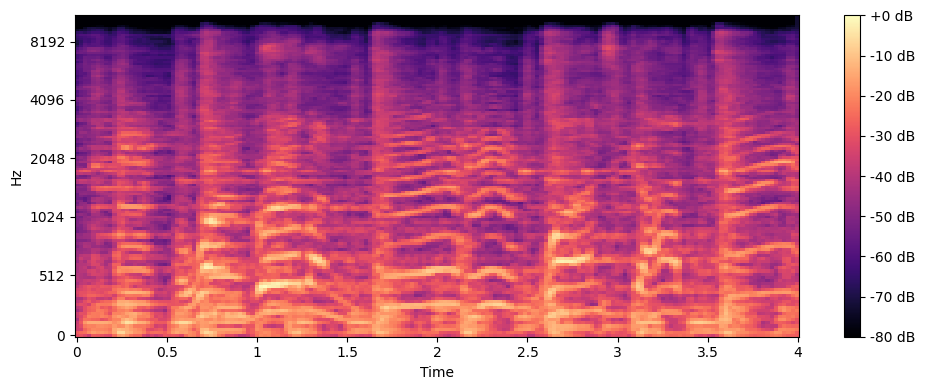

(128, 173)


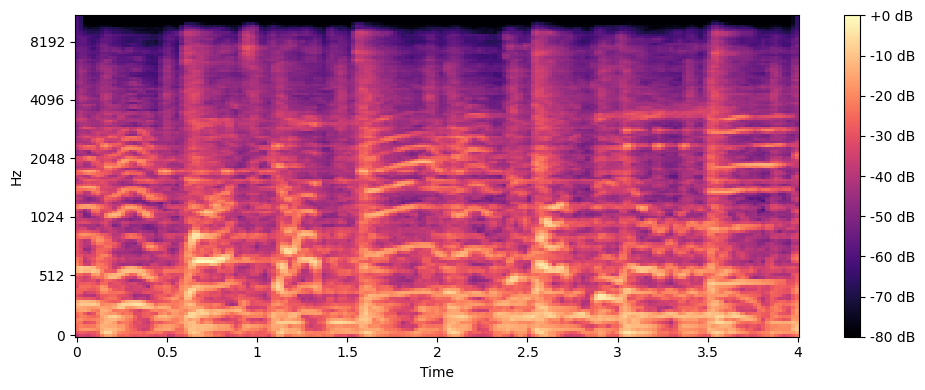

(128, 173)


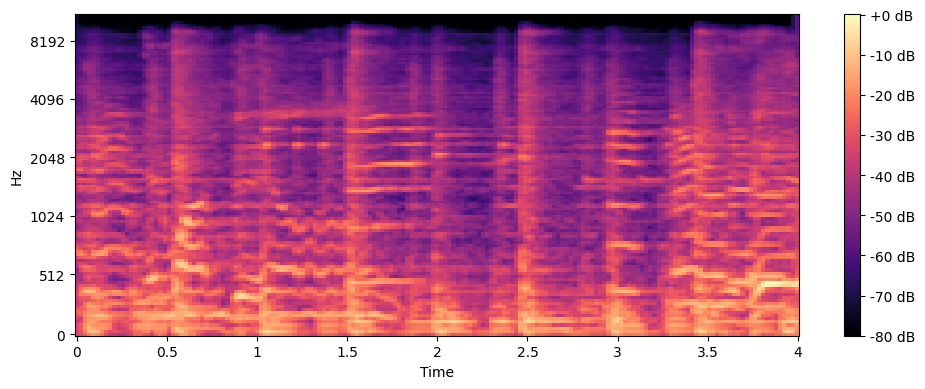

(128, 173)


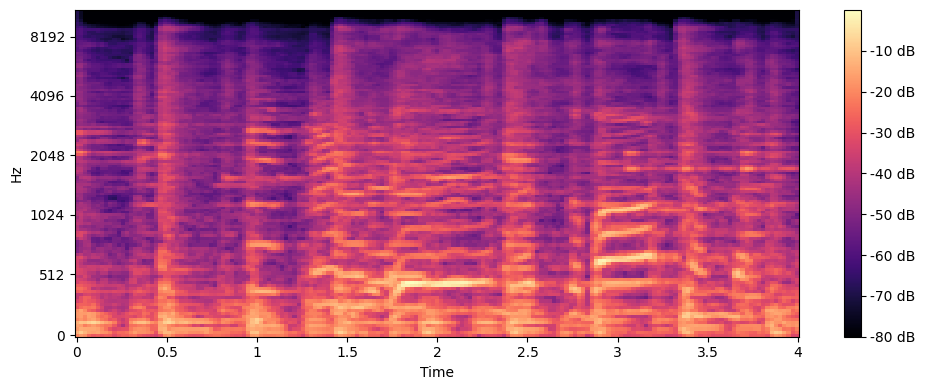

(128, 173)


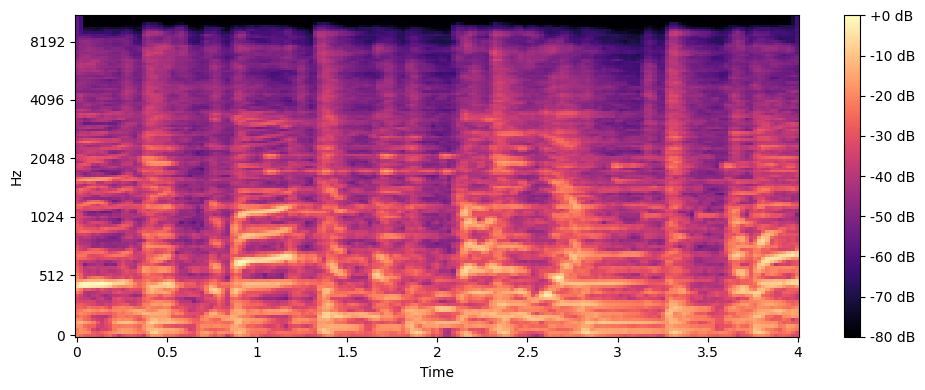

(128, 173)


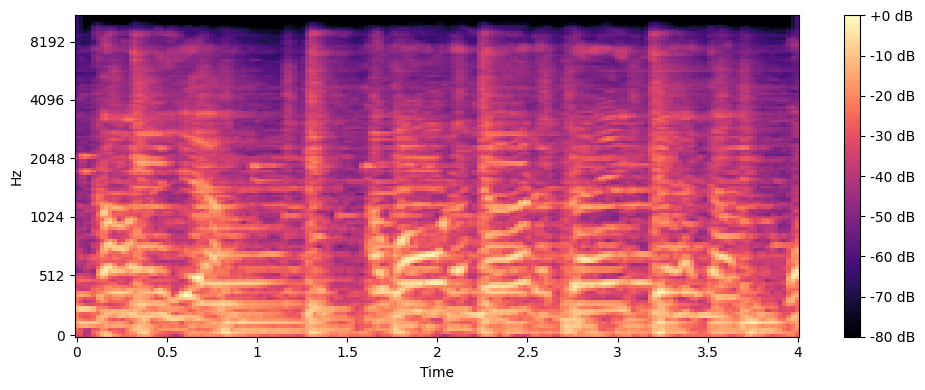

(128, 173)


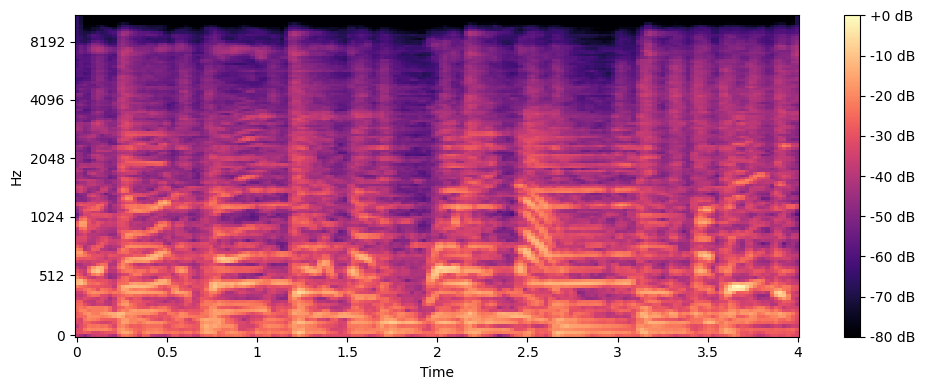

(128, 173)


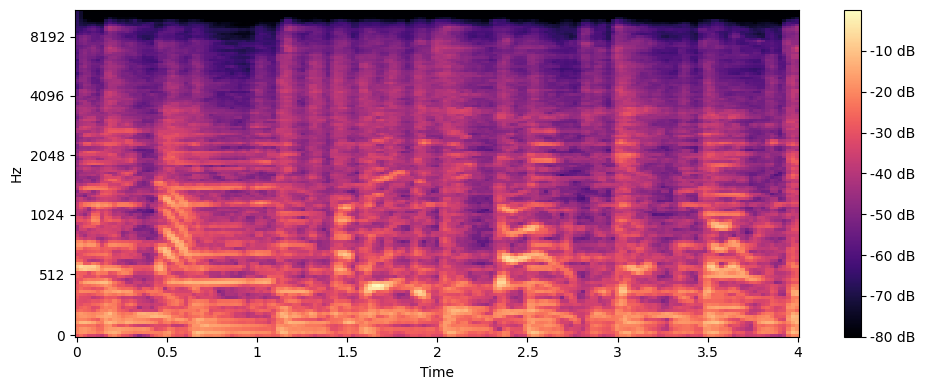

(128, 173)


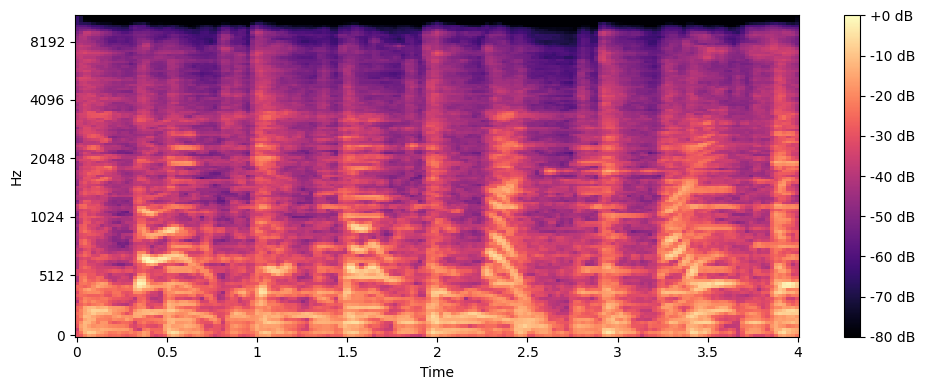

(128, 173)


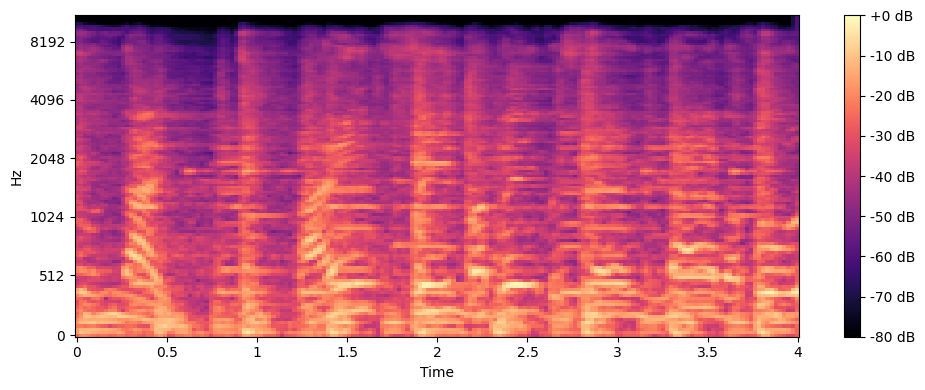

(128, 173)


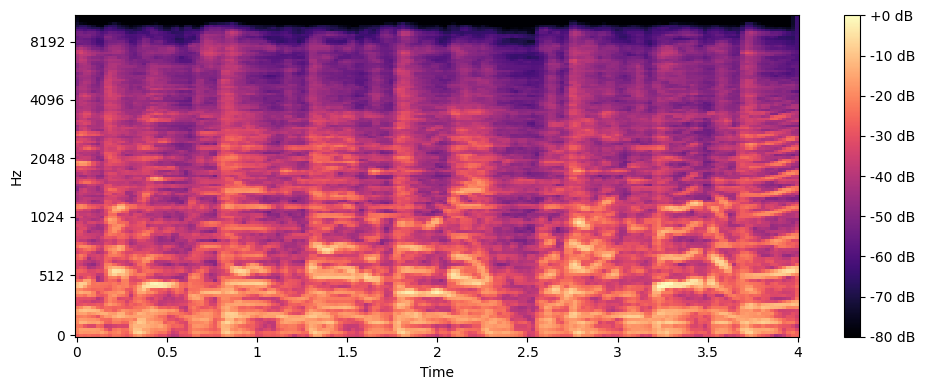

(128, 173)


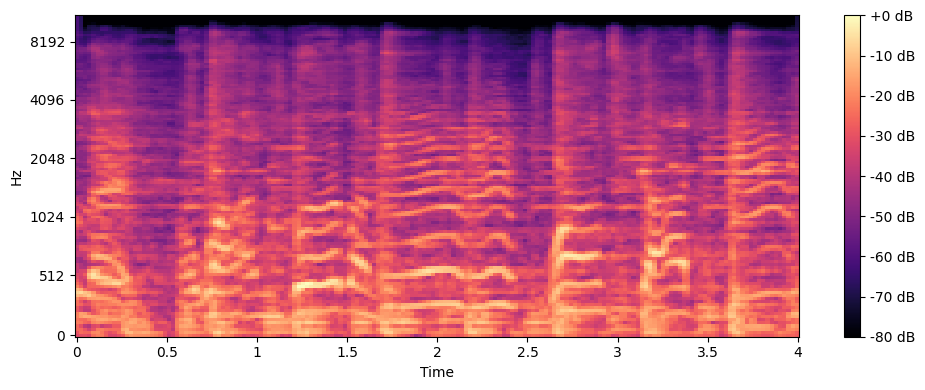

(128, 173)


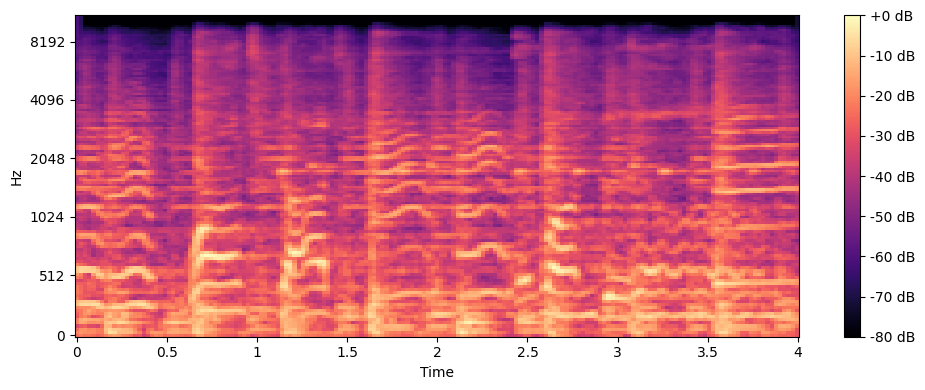

(128, 173)


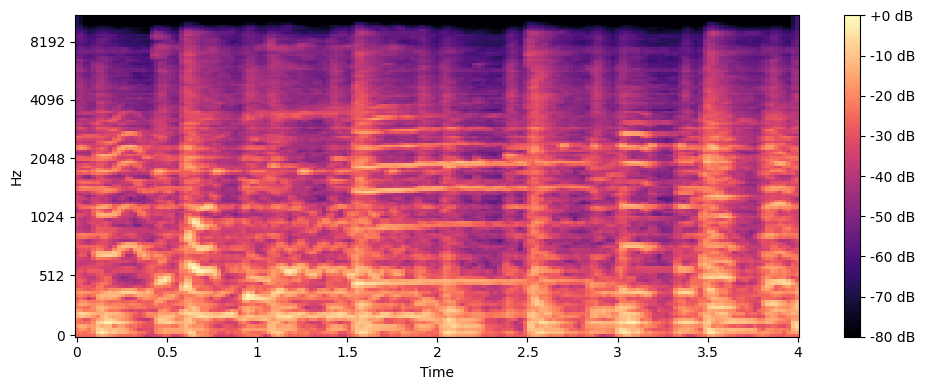

In [140]:
plot_melspectrogram_chunks(data, sr=sample_rate)

We will be using these melspectrograms and put them through convolution and pool layers to then flatten and input into a neural network

## Data Preprocessing

In [144]:
data_dir = './genres_original'
classes = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [142]:
#loading and preprocessing data by converting each wav file to melspectrograms

def load_prep_data(data_dir, classes, target_shape=(160,160)): #210 captures most data in spectrogram
    data = []
    labels = []

    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print("Processing:", class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr= 22050) # maintain original sr

                chunk_length = 4 # in seconds
                overlap_length = 2

                # total samples in file is the sampling rate * duration 
                # converting our chunk lengths to samples
                chunk_samples = chunk_length * sample_rate
                overlap_samples = overlap_length * sample_rate

                # calculating how many chunks we have for iteration
                num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples)))

                for i in range(num_chunks):
                     # want to display each chunk so we need to calculate start and end points
                    start = i * (chunk_samples - overlap_samples)
                    end = start + chunk_samples
                    
                    # chunk data
                    chunk = audio_data[start:end]
    
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)

                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis = -1), target_shape)

                    data.append(mel_spectrogram)
                    labels.append(i_class)

    return np.array(data), np.array(labels)

                

In [145]:
#processing data
data, labels = load_prep_data(data_dir, classes)

Processing: blues
Processing: classical
Processing: country
Processing: disco
Processing: hiphop
Processing: jazz
Processing: metal
Processing: pop
Processing: reggae
Processing: rock


In [146]:
data.shape

(10490, 160, 160, 1)

In [147]:
labels.shape

(10490,)

In [148]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels, num_classes = len(classes)) # converting labels to OHE
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [149]:
labels.shape

(10490, 10)

## splitting data set into train and test sets

In [150]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state = 123)

## Building Model

In [151]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam

In [152]:
model = tf.keras.models.Sequential()

In [153]:
X_train[0].shape

(160, 160, 1)

In [154]:
model.add(Conv2D(filters=32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = X_train[0].shape))
model.add(Conv2D(filters=32, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

/Users/colemak/Documents/music_genre_classifier/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [155]:
model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [156]:
model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [157]:
model.add(tf.keras.layers.Dropout(0.3))

In [158]:
model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [159]:
model.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [160]:
model.add(Dropout(0.3))

In [161]:
model.add(Flatten())

In [162]:
model.add(Dense(units=1200,activation='relu'))

In [163]:
model.add(Dropout(0.45))

In [164]:
#Output Layer
model.add(Dense(units=len(classes),activation='softmax'))

In [165]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 160, 160, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 158, 158, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 79, 79, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 77, 77, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 36, 36, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1200)           │     5,530,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,254,458 (39.12 MB)

 Trainable params: 10,254,458 (39.12 MB)

 Non-trainable params: 0 (0.00 B)

In [166]:
TF_USE_LEGACY_KERAS=True

In [167]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [168]:
checkpoint_filepath = './music_genre_classifier/checkpoint.model.keras'

In [169]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True
)

In [170]:
X_train.shape,Y_train.shape

((8392, 160, 160, 1), (8392, 10))

In [171]:
X_test.shape, Y_test.shape

((2098, 160, 160, 1), (2098, 10))

In [172]:
# Train the model
training_history = model.fit(X_train, Y_train, epochs=25, batch_size=32, validation_data=(X_test, Y_test), callbacks=[model_checkpoint_callback])

Epoch 1/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 219s 829ms/step - accuracy: 0.1953 - loss: 2.1659 - val_accuracy: 0.4395 - val_loss: 1.5918
Epoch 2/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 218s 828ms/step - accuracy: 0.4654 - loss: 1.4869 - val_accuracy: 0.5891 - val_loss: 1.2237
Epoch 3/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 222s 846ms/step - accuracy: 0.5804 - loss: 1.1998 - val_accuracy: 0.6611 - val_loss: 1.0138
Epoch 4/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 224s 851ms/step - accuracy: 0.6568 - loss: 0.9925 - val_accuracy: 0.6711 - val_loss: 0.9696
Epoch 5/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 222s 845ms/step - accuracy: 0.7052 - loss: 0.8704 - val_accuracy: 0.7459 - val_loss: 0.7931
Epoch 6/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 226s 858ms/step - accuracy: 0.7497 - loss: 0.7197 - val_accuracy: 0.7531 - val_loss: 0.7175
Epoch 7/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 218s 828ms/step - accuracy: 0.8021 - loss: 0.5801 - val_accuracy: 0.7993 - val_loss: 0.5889
Epoch 8/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 212s 807ms/step - accuracy: 0.8262 -

In [173]:
model.save('Trained_model_10gn170shape.keras')

In [174]:
save_model =  tf.keras.models.load_model('./music_genre_classifier/checkpoint.model.keras')


In [175]:
save_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 160, 160, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 158, 158, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 79, 79, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 77, 77, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 36, 36, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1200)           │     5,530,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,763,376 (117.35 MB)

 Trainable params: 10,254,458 (39.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,508,918 (78.24 MB)

In [176]:
training_history.history

{'accuracy': [0.2688274681568146,
  0.4979742467403412,
  0.5978312492370605,
  0.6686129570007324,
  0.7200905680656433,
  0.7570304870605469,
  0.7994518876075745,
  0.833412766456604,
  0.8580791354179382,
  0.8792898058891296,
  0.8969256281852722,
  0.9071735143661499,
  0.9143231511116028,
  0.9464966654777527,
  0.9470924735069275,
  0.952216386795044,
  0.9600810408592224,
  0.9646091461181641,
  0.964251697063446,
  0.9688989520072937,
  0.9727120995521545,
  0.9748570322990417,
  0.974380373954773,
  0.9730696082115173,
  0.9831982851028442],
 'loss': [1.9999669790267944,
  1.4192618131637573,
  1.149321436882019,
  0.9510587453842163,
  0.819277286529541,
  0.6959537267684937,
  0.5814124941825867,
  0.49784237146377563,
  0.41174498200416565,
  0.3558706045150757,
  0.29844772815704346,
  0.2813856601715088,
  0.2496802806854248,
  0.1619701236486435,
  0.16581971943378448,
  0.1468830555677414,
  0.12302082031965256,
  0.11536890268325806,
  0.10703927278518677,
  0.094199

In [177]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

## Model Evaluation

In [178]:
train_accuracy=save_model.evaluate(X_train,Y_train,verbose=1)
print(train_accuracy[1])

263/263 ━━━━━━━━━━━━━━━━━━━━ 62s 235ms/step - accuracy: 0.9949 - loss: 0.0146
0.9960677027702332


In [179]:
test_accuracy=save_model.evaluate(X_test,Y_test,verbose=1)
print(test_accuracy[1])

66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step - accuracy: 0.9385 - loss: 0.2576
0.9342230558395386


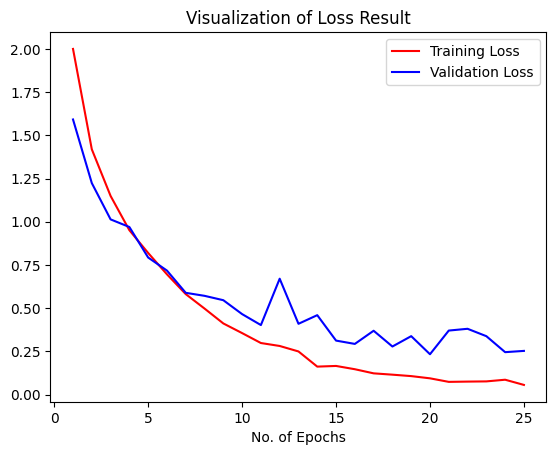

In [180]:
#Visualization of Loss
epochs = [i for i in range(1,26)]
plt.plot(epochs,training_history.history['loss'],color='red',label='Training Loss')
plt.plot(epochs,training_history.history['val_loss'],color='blue',label='Validation Loss')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Loss Result')
plt.legend()
plt.show()

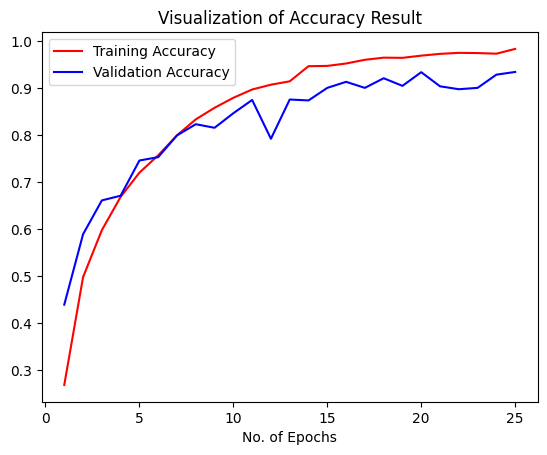

In [181]:
#Accuracy Visualization
plt.plot(epochs,training_history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,training_history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [182]:
X_test.shape

(2098, 160, 160, 1)

In [183]:
y_pred = save_model.predict(X_test)
y_pred

66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step


array([[8.2527390e-07, 1.0714175e-10, 1.4193332e-09, ..., 9.4622016e-01,
        9.2013289e-07, 1.4006041e-05],
       [5.6551666e-08, 1.5987555e-12, 5.1956281e-06, ..., 1.9191776e-07,
        7.4457633e-01, 1.2356602e-07],
       [1.5485337e-12, 9.9999571e-01, 1.0339233e-12, ..., 4.7236619e-09,
        7.9231406e-11, 6.3196964e-08],
       ...,
       [7.1773928e-07, 2.5229665e-09, 1.3360840e-05, ..., 1.0195029e-05,
        9.9006104e-01, 2.1715219e-05],
       [8.7462922e-07, 1.2715191e-06, 5.4600141e-06, ..., 3.3105214e-05,
        5.8665588e-09, 9.9584585e-01],
       [5.8250106e-11, 2.1859012e-14, 4.4187401e-15, ..., 6.9526409e-06,
        4.8567908e-06, 8.3388649e-08]], dtype=float32)

In [184]:
y_pred.shape

(2098, 10)

In [185]:
Y_test.shape

(2098, 10)

In [186]:
pred_categories = np.argmax(y_pred, axis=1)
pred_categories

array([7, 8, 1, ..., 8, 9, 4])

In [187]:
Y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [188]:
true_categories = np.argmax(Y_test, axis=1)
true_categories

array([7, 8, 1, ..., 8, 6, 4])

In [189]:
from sklearn.metrics import confusion_matrix,classification_report
confusion_matrix = confusion_matrix(true_categories,pred_categories)
# Precision Recall F1score
print(classification_report(true_categories,pred_categories,target_names=classes))

              precision    recall  f1-score   support

       blues       0.93      0.98      0.95       217
   classical       0.93      0.98      0.95       206
     country       0.89      0.90      0.89       208
       disco       0.97      0.93      0.95       204
      hiphop       0.94      0.95      0.95       192
        jazz       0.91      0.94      0.93       231
       metal       0.96      0.98      0.97       206
         pop       0.97      0.88      0.92       218
      reggae       0.98      0.92      0.95       225
        rock       0.87      0.88      0.88       191

    accuracy                           0.93      2098
   macro avg       0.93      0.93      0.93      2098
weighted avg       0.94      0.93      0.93      2098



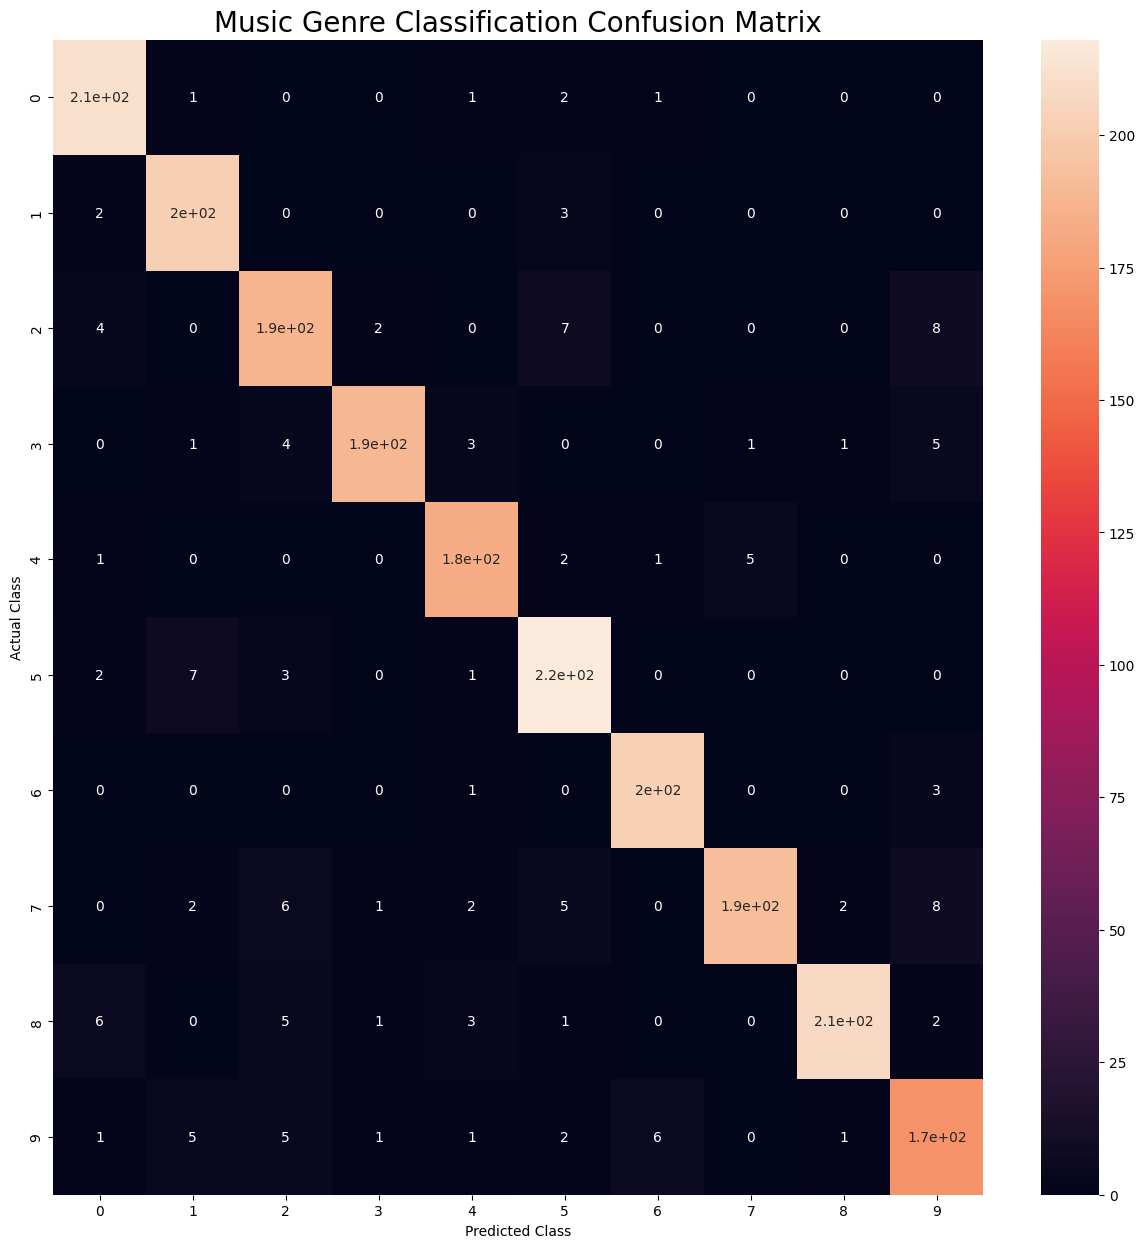

In [190]:
plt.figure(figsize=(15, 15))
sns.heatmap(confusion_matrix,annot=True)

plt.xlabel('Predicted Class',fontsize = 10)
plt.ylabel('Actual Class',fontsize = 10)
plt.title('Music Genre Classification Confusion Matrix',fontsize = 20)
plt.show()